<a href="https://colab.research.google.com/github/tanay2001/Stock-Trading-Bot-/blob/master/Models/Conv_LSTM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate, LSTM
import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import gc
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
merged_data = pd.DataFrame()
os.chdir('/content/drive/My Drive/stonks_data/hist/')
for filename in os.listdir(os.getcwd()):
  try:
   os.chdir(filename)
   print(filename)
   for datafile in os.listdir(os.getcwd()):
          dataset=pd.read_csv(datafile)
          dataset.index = [datafile.split('.')[0]]*dataset.shape[0]
          merged_data = merged_data.append(dataset)
   os.chdir('/content/drive/My Drive/stonks_data/hist/')
  except:
    pass

Auto 
Banks
Cement and Construction
Finance
IT
Metals
Petroleum
Pharma
Retail 
Entertainment
Telecom
FMCG
Chemicals
Indices


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    Xtrain = []
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=10, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.shuffle(shuffle_buffer)
    gc.collect()
    for X in ds:
      Xtrain.append(X.numpy())
    return  np.asarray(Xtrain)

In [5]:
 merged_data.reset_index(inplace = True)
 data = merged_data.groupby('index')

In [6]:
data.head()

,index,Date,High,Low,Open,Close,Volume,ma7,ma21,12ema,26ema,MACD,20std,upper_band,lower_band,ema,sar,rsi
0,M&M,2005-01-03,69.925003,68.387497,68.387497,69.556297,5277192.0,NaN,NaN,69.556297,69.556297,0.000000,NaN,NaN,NaN,69.556297,60.443844,26.321832
1,M&M,2005-01-04,70.375000,69.012497,69.993797,69.218803,3871624.0,NaN,NaN,69.504375,69.531298,-0.026923,NaN,NaN,NaN,69.303177,60.633467,26.321832
2,M&M,2005-01-05,69.312500,63.900002,68.875000,67.581299,5510344.0,NaN,NaN,69.208517,69.386853,-0.178336,NaN,NaN,NaN,68.111107,61.023128,26.321832
3,M&M,2005-01-06,67.625000,65.437500,67.331299,66.412498,5780816.0,NaN,NaN,68.778361,69.166531,-0.388170,NaN,NaN,NaN,66.964546,61.397203,26.321832
4,M&M,2005-01-07,67.025002,65.506203,67.025002,65.956299,2868312.0,NaN,NaN,68.344197,68.928736,-0.584539,NaN,NaN,NaN,66.289604,61.756315,26.321832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294923,^BSESN,2005-01-03,6684.220215,6626.490234,6626.490234,6679.200195,12000.0,NaN,NaN,6679.200195,6679.200195,0.000000,NaN,NaN,NaN,6679.200195,6399.713059,24.999988
294924,^BSESN,2005-01-04,6696.310059,6640.899902,6683.560059,6651.009766,16600.0,NaN,NaN,6674.863206,6677.112015,-2.248809,NaN,NaN,NaN,6658.057373,6405.403203,24.999988
294925,^BSESN,2005-01-05,6629.979980,6337.609863,6628.890137,6458.839844,24000.0,NaN,NaN,6641.628843,6660.943706,-19.314864,NaN,NaN,NaN,6520.137545,6696.310059,24.999988
294926,^BSESN,2005-01-06,6481.229980,6325.359863,6447.270020,6367.390137,22200.0,NaN,NaN,6599.438273,6639.198997,-39.760725,NaN,NaN,NaN,6417.033044,6696.310059,24.999988


In [45]:
final = np.empty((0,60,11))
for grp in tqdm(merged_data['index'].unique()):
    train = pd.DataFrame(data.get_group(grp))
    train['ma50'] = train['Close'].rolling(50).mean()
    train['ma150'] = train['Close'].rolling(150).mean()
    train['trend'] = train['ma150'] - train['ma50']
    train['upper_level'] = train['upper_band'] - train['High']
    train['lower_level'] = train['Low']-train['lower_band']
    train['trend_2'] = train['26ema'] - train['12ema']
    train.dropna(inplace = True)
    series = windowed_dataset(train[['Close','ma7','trend','12ema','ma21','ma50','MACD','upper_level','lower_level','sar','rsi']].values, 60, 32, 100)
    if series.shape[0] !=0:
      for i in range(10):
        series[:,:,i]  = (series[:,:,i] - series[:,:,i].mean())/series[:,:,i].std()
        #series[:,:,i] = (series[:,:,i] - series[:,:,i].min()) / (series[:,:,i].max() - series[:,:,i].min())
        #series[:,:,i] = series[:,:,i] * (1 - 0) + 0
      final = np.append(final,values = series, axis =0)
    gc.collect()
    del train, series

100%|██████████| 89/89 [00:34<00:00,  2.56it/s]


In [46]:
final.shape

(28071, 60, 11)

In [ ]:
#ma50 , ma200 , sar levels , OBV ,india VIX (volality index)

In [47]:

encoder_test = final[:5000,:100]
decoder_test = final[:5000,-10:]

In [48]:

encoder_input_data = final[5000:,:100]

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = final[5000:,-10:]

In [49]:
decoder_test.shape

(5000, 10, 11)

In [50]:
decoder_target_data.shape

(23071, 10, 11)

In [51]:
encoder_input_data.shape

(23071, 60, 11)

In [73]:
def create_model(n):
    def slice(x, seq_length):
        return x[:,-seq_length:,:]
    model = tf.keras.models.Sequential([
      Conv1D(filters=32, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, n]),
      tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
      Dense(200, activation="relu"),
      Dense(30, activation="relu"),
      Dense(1),
      Lambda(slice, arguments={'seq_length':10})

    ])
    return model

In [53]:
model = create_model()

In [54]:
model.compile(tf.keras.optimizers.Adam(lr = 0.0001), loss='mse', metrics ='mse')
checkpoint_path = "/content/drive/My Drive/stonks_data/hist/"
checkpoint_dir = os.path.dirname(checkpoint_path)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=5)

history = model.fit(encoder_input_data, decoder_target_data[:,:,:1],
                    batch_size =128,
                    epochs=100, validation_data = (encoder_test, decoder_test[:,:,:1]), callbacks =[callback])

Epoch 1/100
181/181 [==============================] - 5s 27ms/step - loss: 0.2274 - mse: 0.2274 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 2/100
181/181 [==============================] - 3s 19ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 3/100
181/181 [==============================] - 4s 20ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 4/100
181/181 [==============================] - 4s 20ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/100
181/181 [==============================] - 3s 19ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 6/100
181/181 [==============================] - 3s 18ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 7/100
181/181 [==============================] - 3s 19ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 8/100
181/181 [==============================] - 3s 18ms

In [19]:
#model.save_weights(checkpoint_dir)

In [84]:
model2 = create_model(10)
checkpoint_path = "/content/drive/My Drive/stonks_data/hist/"
checkpoint_dir2 = os.path.dirname(checkpoint_path)
model2.load_weights(checkpoint_dir2)

ValueError: ignored

In [77]:
checkpoint_path = "/content/drive/My Drive/stonks_data/hist/models"
checkpoint_dir = os.path.dirname(checkpoint_path)
model.save_weights(checkpoint_dir)

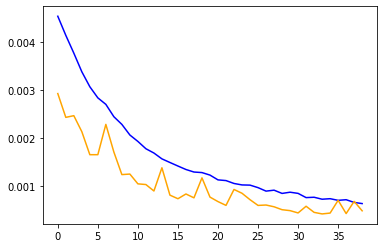

In [55]:
plt.plot(history.history['mse'][5:], color ='blue')
plt.plot(history.history['val_mse'][5:], color ='orange')

In [81]:
def pred(n, train ,actual,m):
  results =model(train[n:n+1,:,:])
  plt.figure(figsize=(10,6)) 
  plt.plot(range(150,210),final[n,-60:,0])
  #plt.plot(range(150,200),train[n,-50:,3])

  plt.plot(range(200,210), results[0,:,0], color ='red')
  plt.plot(range(200,210),actual[n,:,0], color ='black')


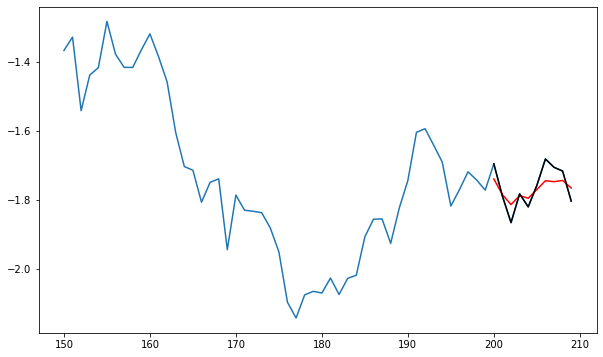

In [82]:
pred(2214,encoder_test, decoder_test,5)

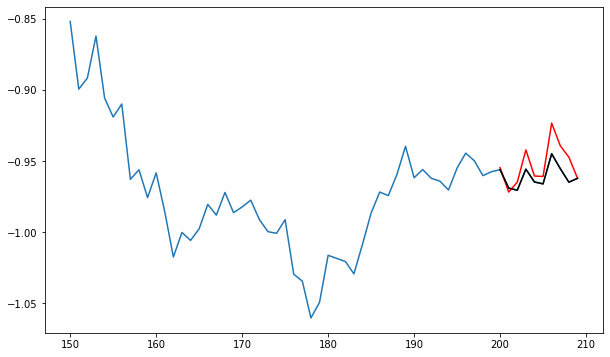

In [58]:
pred(4914,encoder_test, decoder_test,5)

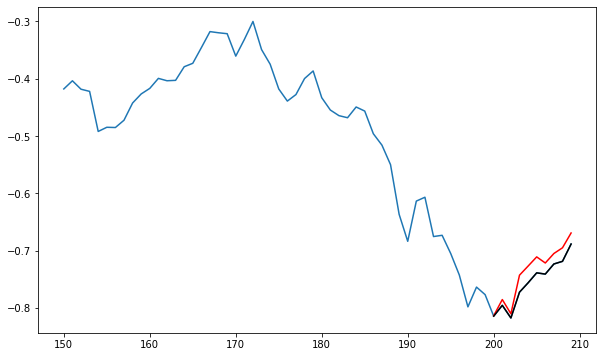

In [59]:
pred(510,encoder_test, decoder_test,5)

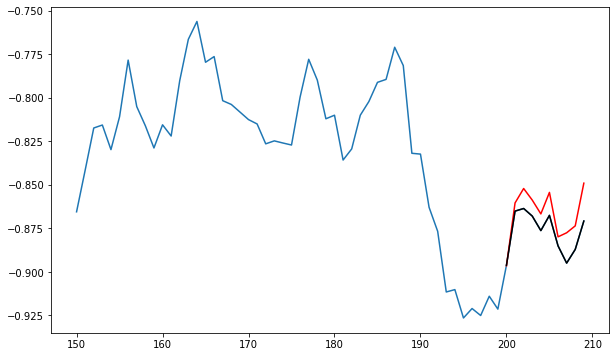

In [60]:
pred(514,encoder_test, decoder_test,5)

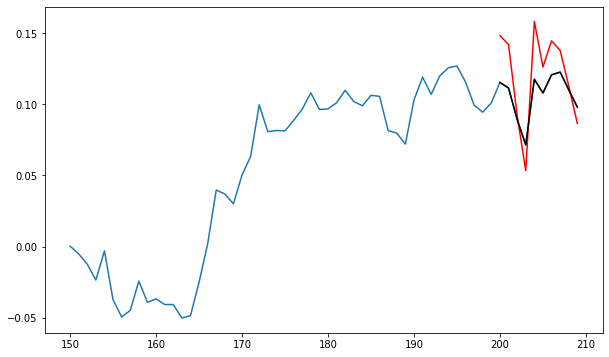

In [61]:
pred(897,encoder_test, decoder_test,5)

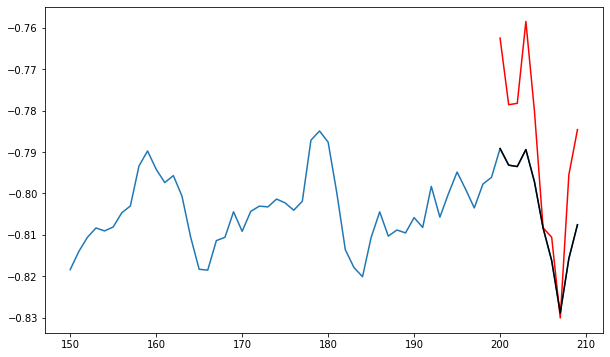

In [78]:
pred(857,encoder_test, decoder_test,5)

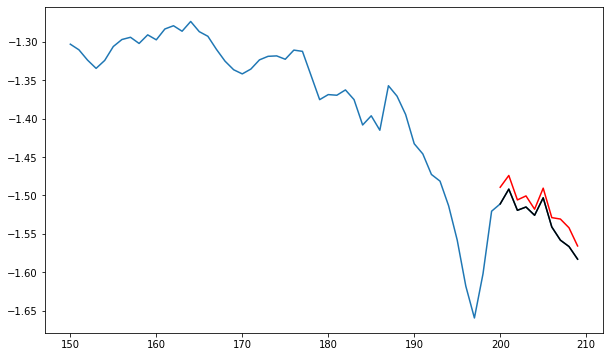

In [65]:
pred(65,encoder_test, decoder_test,5)

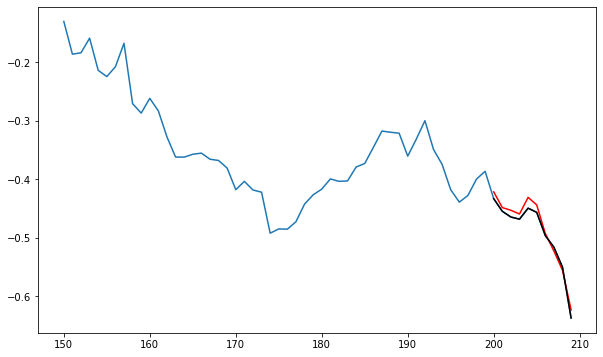

In [66]:
pred(409,encoder_test, decoder_test,5)

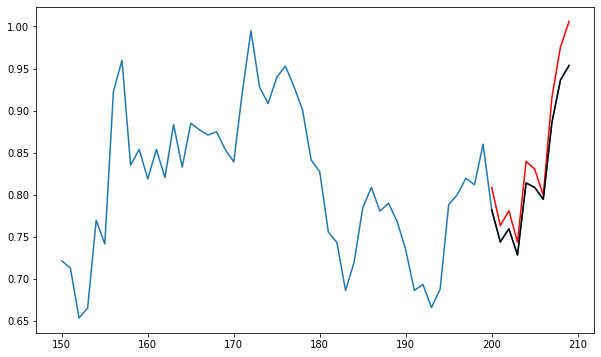

In [67]:
pred(1409,encoder_test, decoder_test,5)

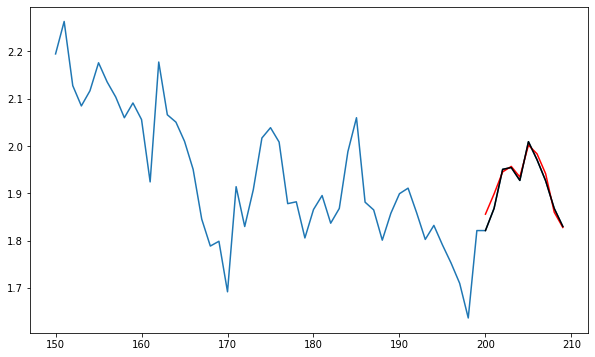

In [68]:
pred(1449,encoder_test, decoder_test,5)

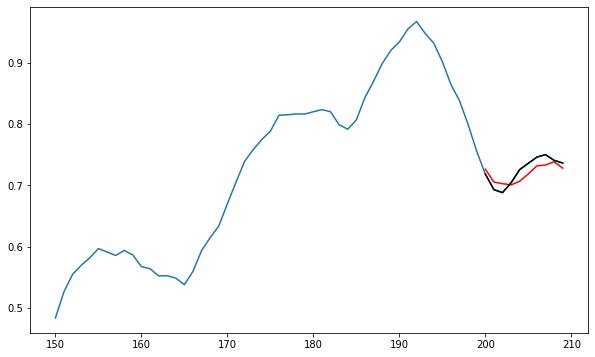

In [32]:
pred(1249,encoder_test, decoder_test,5)

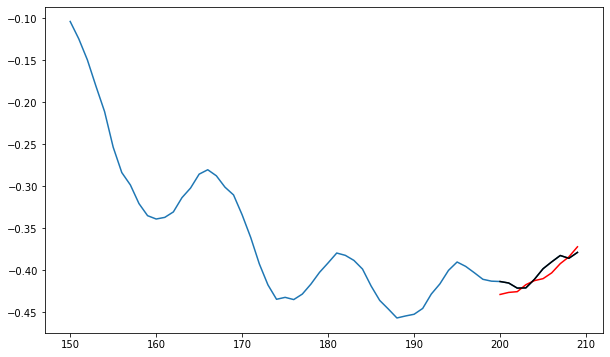

In [34]:
pred(111,encoder_test, decoder_test,5)


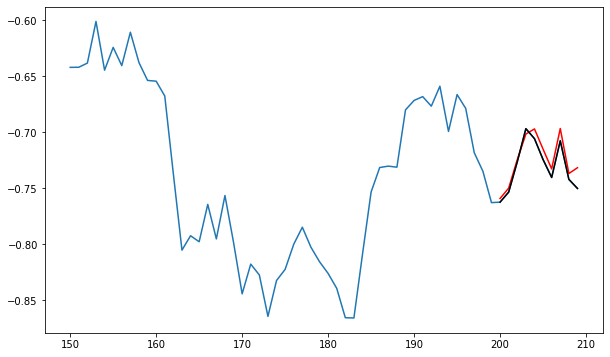

In [70]:
pred(19,encoder_test, decoder_test,5)

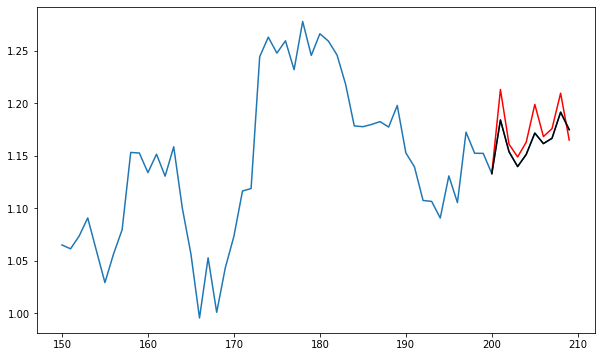

In [69]:
pred(232,encoder_test, decoder_test,5)

In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 327kB 5.2MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456458 sha256=dd1f1eb3e89527bb23e77db771093d2df209fd1ef2658f5b265221a2b1d24933
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
explainer = shap.DeepExplainer(model , data = encoder_input_data, )

keras is no longer supported, please use tf.keras instead.


AssertionError: ignored